In [5]:
# ========== IMPORTS ==========
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [6]:
# ========== LOAD DATA ==========
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_data = pd.read_csv("../data/raw/IpAddress_to_Country.csv")
credit = pd.read_csv("../data/raw/creditcard.csv")

In [7]:
# ========== HANDLE MISSING VALUES ==========
print("Missing Values in Fraud_Data:\n", fraud.isnull().sum())
fraud.dropna(inplace=True)

print("Missing Values in IP Data:\n", ip_data.isnull().sum())
ip_data.dropna(inplace=True)

print("Missing Values in Credit Data:\n", credit.isnull().sum())
credit.dropna(inplace=True)

Missing Values in Fraud_Data:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Missing Values in IP Data:
 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
Missing Values in Credit Data:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [8]:
# Remove duplicates
fraud.drop_duplicates(inplace=True)
ip_data.drop_duplicates(inplace=True)
credit.drop_duplicates(inplace=True)


In [9]:
# Correct data types
fraud["signup_time"] = pd.to_datetime(fraud["signup_time"])
fraud["purchase_time"] = pd.to_datetime(fraud["purchase_time"])

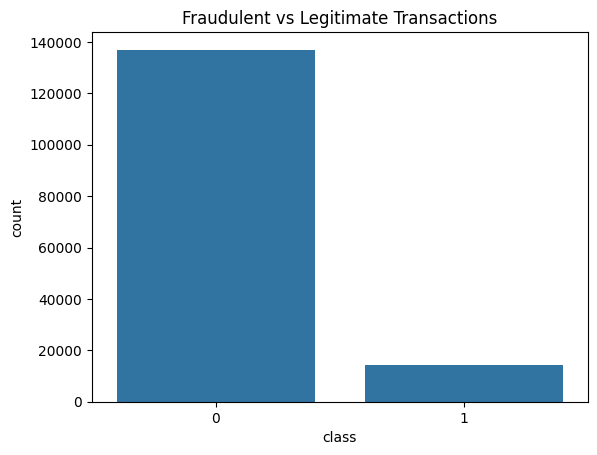

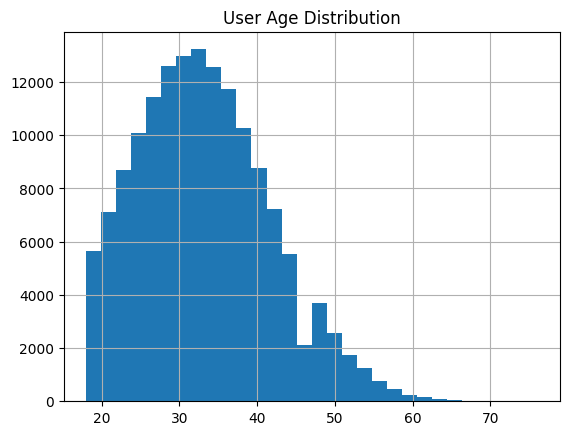

In [10]:
# ========== EDA: UNIVARIATE ==========
sns.countplot(data=fraud, x="class")
plt.title("Fraudulent vs Legitimate Transactions")
plt.show()

fraud["age"].hist(bins=30)
plt.title("User Age Distribution")
plt.show()

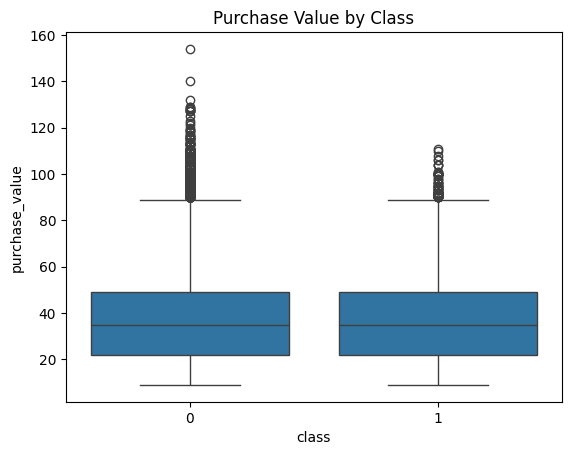

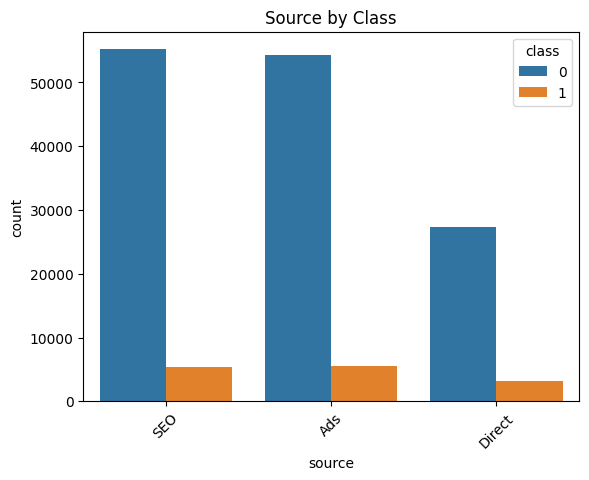

In [11]:
# ========== EDA: BIVARIATE ==========
sns.boxplot(data=fraud, x="class", y="purchase_value")
plt.title("Purchase Value by Class")
plt.show()

sns.countplot(data=fraud, x="source", hue="class")
plt.title("Source by Class")
plt.xticks(rotation=45)
plt.show()

In [12]:
# ========== GEOLOCATION MERGE ==========
# Convert IP address to integer
import ipaddress

def ip_to_int(ip):
    try:
        return int(ipaddress.IPv4Address(ip))
    except:
        return np.nan

fraud["ip_integer"] = fraud["ip_address"].apply(ip_to_int)
ip_data["lower_bound_ip_int"] = ip_data["lower_bound_ip_address"].apply(ip_to_int)
ip_data["upper_bound_ip_int"] = ip_data["upper_bound_ip_address"].apply(ip_to_int)


In [13]:
# Merge using range join logic
def get_country(ip):
    match = ip_data[(ip_data["lower_bound_ip_int"] <= ip) & (ip_data["upper_bound_ip_int"] >= ip)]
    if not match.empty:
        return match["country"].values[0]
    return "Unknown"

fraud["country"] = fraud["ip_integer"].apply(get_country)

In [14]:
# ========== FEATURE ENGINEERING ==========
fraud["transaction_freq"] = fraud.groupby("user_id")["purchase_time"].transform("count")
fraud["transaction_velocity"] = fraud.groupby("user_id")["purchase_time"].transform(lambda x: (x.max() - x.min()).total_seconds())

fraud["hour_of_day"] = fraud["purchase_time"].dt.hour
fraud["day_of_week"] = fraud["purchase_time"].dt.dayofweek
fraud["time_since_signup"] = (fraud["purchase_time"] - fraud["signup_time"]).dt.total_seconds()


In [15]:
# ========== HANDLE CLASS IMBALANCE ==========
X = fraud.drop(columns=["class", "signup_time", "purchase_time", "ip_address", "ip_integer", "user_id", "device_id"])
y = fraud["class"]

# Encoding categorical variables before sampling
X = pd.get_dummies(X, columns=["source", "browser", "sex", "country"], drop_first=True)

# Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [16]:
# ========== NORMALIZATION & SCALING ==========
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# X_train_scaled and X_test_scaled are ready for modeling

# ========== SAVE PROCESSED DATA ==========
pd.DataFrame(X_train_scaled).to_csv("../data/processed/X_train.csv", index=False)
pd.DataFrame(X_test_scaled).to_csv("../data/processed/X_test.csv", index=False)
pd.DataFrame(y_train_balanced).to_csv("../data/processed/y_train.csv", index=False)
pd.DataFrame(y_test).to_csv("../data/processed/y_test.csv", index=False)

print("✅ Task 1 preprocessing completed and files saved to `data/processed/`.")

✅ Task 1 preprocessing completed and files saved to `data/processed/`.
